## Valuation of Apple Inc. (AAPL) European vanilla call options


### 0. Abstract
Valuation of stock option in Black-Scholes world, Monte Carlo simulation, calculation of Greeks ($\Delta$,$\Gamma$,$\nu$,$\Theta$,$\rho$,$\Omega$),implied volatility and volatility smile. 

### 1. Intro

Option in financial context is derivative contract that derives its value from another instrument called underlying. Options are usually available for interest rates, stocks, currencies and indexes. There are two typical types of options contracts, denoted calls and puts.

A call option gives the buyer the right but not obligation to buy an underlying instrument at a contract-specified price (known as the strike price) at a certain date (called the exercise date) from the options seller.  By contrast, the put option gives the buyer the right but not the obligation to sell the underlying instrument at a strike price to the options seller. Usually, options must be traded in lots of 100.


In [1]:
#load required libraries, print details of machine and python
import os, sys
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from scipy.stats import norm
from random import gauss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
import warnings
from math import *
import matplotlib as mpl
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn
p = print
p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Darwin x86_64

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


### 1. Data
Options data is usually hard to find for free but the main exchange in US, Chicago Board of Exchange (CBOE), offers daily options chains (list of all available contracts) on http://www.cboe.com/delayedquote/quote-table otherwise AAPL.dat may be found on https://github.com/0x3W/Quant/blob/master/AAPL.dat

Considering the structure of the document, it requires a bit of processing in order to put in adequate form for valuation. Additionally, appropriate valuation requires use of historical volatility which is not included in data from CBOE hence prices from IEX exchange for APPL stock are used via pandas datareader function in order to calculate it.

Historical volatility represents annualized standard deviation of the changes in the logarithm of the price of the AAPL stock.

5y


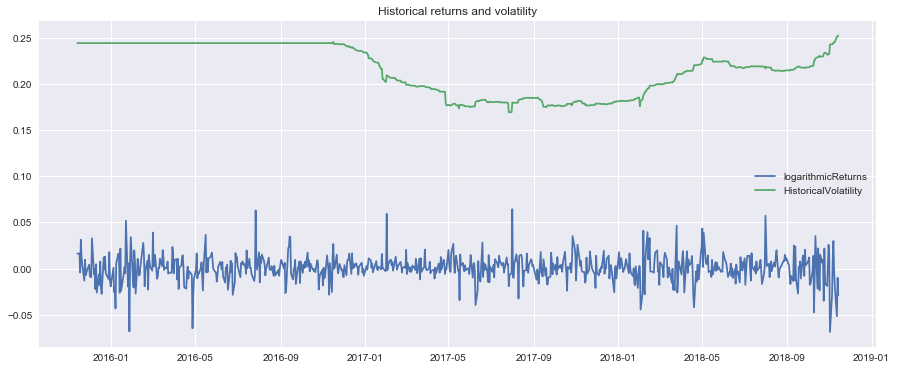

In [2]:
#calculate historical volatility
start = '2015-11-13'
end = '2018-11-14'
aapl = web.DataReader('AAPL', 'iex', start, end)
aapl['logarithmicReturns'] = np.log(aapl.close / aapl.close.shift(1))
aapl['HistoricalVolatility'] = aapl.logarithmicReturns.rolling(252).std()*np.sqrt(252)
aapl['tim'] = pd.to_datetime(aapl.index, format='%Y-%m-%d')
aapl = aapl.set_index('tim')
aapl = aapl.fillna(method='bfill')
sns.set(rc={'figure.figsize':(15,6)})
plt.title("Historical returns and volatility")
plt.plot(aapl['logarithmicReturns'])
plt.plot(aapl['HistoricalVolatility'])
plt.legend()
plt.show()

In [136]:
#Process options chain for one ticker from CBOE website 
with open('AAPL.dat','r') as f:
    underlying = float(f.readline().split(',')[1])
dat = pd.read_csv('/Users/Dovla/Downloads/AAPL.dat', sep=",", skiprows=2)
calls = dat.iloc[:,0:7]
calls['Y'], calls['M'],calls['D'],calls['K'],calls['Code'] = calls['Calls'].str.split(' ', -1).str
calls['Code'],calls['Exch'] = calls['Code'].str.split('-', -1).str
calls['K'] = calls.K.astype(float)
calls['Time'] = pd.to_datetime(calls.Y+calls.M+calls.D,format='%Y%b%d')
calls['Time1'] = calls['Time'] - calls['Time'][0]
calls['Ti'] = (calls['Time1'].dt.days+2) / 365
calls['S'] = underlying
calls['r'] = 0.03
calls['opMidPrice'] = (calls['Bid'] + calls['Ask'])/2
calls = calls[calls['Exch'].isnull()]
calls1 = calls[['S','K','Ti','r','opMidPrice']]
calls1['sigma'] = aapl.HistoricalVolatility[-1]
calls1 = calls1.reset_index(drop=True)
calls1 = calls1.iloc[350:750,:]
calls1.head()

,S,K,Ti,r,opMidPrice,sigma
350,186.8,212.5,0.120548,0.03,1.055,0.252236
351,186.8,215.0,0.120548,0.03,0.835,0.252236
352,186.8,217.5,0.120548,0.03,0.690,0.252236
353,186.8,220.0,0.120548,0.03,0.525,0.252236
354,186.8,222.5,0.120548,0.03,0.490,0.252236


### 2. Black-Scholes formula

The model assumes that the price of the underlying asset follows a geometric Brownian motion (GBM):

$$ dS_{t} = \mu S_{t} dt+ \sigma S_{t} dW_{t}$$ 

and price of call option depends on several parameters $S_0$ is the underlying price at time $0$, $r$ is the risk-free rate, $\sigma$ is the volatility of the underlying, $T$ is the maturity of the option, $K$ the strike price and $\delta$ the dividend rate (which is skipped in this example for simplicity). 

$$call(K, T) = S_0 e^{-\delta T} N(d_1) - Ke^{rT}N(d_2)$$

with :
$$d_1=\frac{ln\left(\frac{S_0}{K}\right)+(r-\delta+\frac{\sigma^2}{2})T}{\sigma\sqrt{T}}$$

$$d_2=d_1 - \sigma\sqrt{T}$$

where $N(.)$ represents the cumulative distribution function (cdf) of the standard normal distribution.

Call option value is calculated in vectorized fashion while the correctness of the implemented formula is tested on following example strike $K=100$, $T=1$ year, $S_0=100$, $r$=0.05 and $\sigma$ = 0.2.

\begin{align*}
  d_1&=\frac{\ln \left(\frac{100}{100} \right) +
  \left(0.05+\frac{0.2^2}{2}\right)(1-0)}{0.2 \sqrt{1-0}}\\&=0.35\\
  d_2&=0.35-0.2*\sqrt{1-0} \\&= 0.15\\
  call(0)&=100 N(0.35) - e^{-0.05\cdot 1}100N(0.15)\\&=10.45
\end{align*}


In [137]:
def d1(x):
    d1 = (np.log(x.S/x.K) + (x.r + x.sigma**2/2)*x.Ti) / (x.sigma * np.sqrt(x.Ti))
    return d1
def d2(x):
    d2 = x.d1 - x.sigma * np.sqrt(x.Ti)
    return d2
def call(x):
    c0 =  x.S * norm.cdf(x.d1) - x.K * exp(-x.r*(x.Ti)) * norm.cdf(x.d2)
    return c0

#calculate d1,d2 and example call price
examp = pd.DataFrame({'S':[100],'K':[100],'Ti':[1],'r':[0.05],'sigma':[0.2]})
examp['d1'] = examp.apply(d1, axis=1)
examp['d2'] = examp.apply(d2, axis=1)
examp['opBSprice'] = examp.apply(call, axis=1)
p('Price of the example call option = ',examp.opBSprice.iloc[0], ' and should be 10.45')

#calculate d1,d2 and call price of whole option chain in vectorized fashion
calls1['d1'] = calls1.apply(d1, axis=1)
calls1['d2'] = calls1.apply(d2, axis=1)
calls1['opBSprice'] = calls1.apply(call, axis=1)

Price of the example call option =  10.450583572185565  and should be 10.45


### 3. Greeks
The sensitivities of the option price with respect to the first four parameters are called the Greeks and are widely used for hedging purposes. Impact of these parameters is calculated by taking partial derivatives.

- Delta $\Delta$ measures an option's price expected change per 1 unit change in price of underlying. 

$$ \Delta_{call}= \frac{\partial c}{\partial S} = e^{-\delta T} N(d_1)$$

- Gamma $\Gamma$ is the rate of change of $\Delta$. 
	$$ \Gamma= \frac{\partial^2 c}{\partial S^2} =\frac{\partial^2 p}{\partial S^2} = \frac{ e^{-\delta T}N'(d_1)}{S_0 \sigma \sqrt{T}}$$

- Vega $\nu$ measures the rate of change in an option's price per 1 percent change in the implied volatility of the underlying stock.

$$\nu =\frac{\partial c}{\partial \sigma} =\frac{\partial p}{\partial \sigma}= S_0  e^{-\delta T} \sqrt{T} N'(d_1)$$

- Theta $\Theta$ measures time-decay which is change in price for one day decrease in time to expiration. 

    $$\theta_{call} = \frac{\partial c}{\partial t} = -\frac{S_0 e^{-\delta T} \sigma N'(d_1)}{2\sqrt{T}} +\delta S_0 e^{-\delta T} N(d_1) - rKe^{-rT}N(d_2)$$

- Rho $\rho$ measures the expected change in an option's price per 1 percent change in interest rates. 

  $$\rho_{call} = \frac{\partial c}{\partial r} = KTe^{-rT}N(d_2)$$

- Omega $\Omega$ is the percentage change in option value per percentage change in the underlying price, a measure of leverage.
$$\Omega = \Delta \frac{S}{f} $$

In [138]:
def delta(x):
    return norm.cdf(x.d1)
def gamma(x):
    gamma = norm.pdf(x.d1) / (x.S * x.sigma * sqrt(x.Ti))
    return gamma
def theta(x):
    theta = -(x.S*norm.pdf(x.d1)*x.sigma / (2*sqrt(x.Ti))) - (0.03 * x.K*exp(-0.03*x.Ti)*norm.cdf(x.d2))
    return theta
def rho(x):
    rho = ((x.Ti) * x.K * exp(-0.03*(x.Ti)) * norm.cdf(x.d2))
    return rho
def vega(x):
    vega = (x.S * norm.pdf(x.d1) * np.sqrt(x.Ti))
    return vega

In [139]:
calls1['delta'] = calls1.apply(delta, axis=1)
calls1['gamma'] = calls1.apply(gamma, axis=1)
calls1['vega'] = calls1.apply(vega, axis=1)
calls1['theta'] = calls1.apply(theta, axis=1)
calls1['rho'] = calls1.apply(rho, axis=1)
calls1.head()

,S,K,Ti,r,opMidPrice,sigma,d1,d2,opBSprice,delta,gamma,vega,theta,rho
350,186.8,212.5,0.120548,0.03,1.055,0.252236,-1.386814,-1.474391,0.596397,0.082749,0.009322,9.890942,-10.793804,1.791482
351,186.8,215.0,0.120548,0.03,0.835,0.252236,-1.520367,-1.607943,0.442550,0.064209,0.007677,8.145690,-8.868628,1.392543
352,186.8,217.5,0.120548,0.03,0.690,0.252236,-1.652375,-1.739951,0.325033,0.049229,0.006227,6.606637,-7.178036,1.069376
353,186.8,220.0,0.120548,0.03,0.525,0.252236,-1.782875,-1.870451,0.236324,0.037303,0.004976,5.279995,-5.725924,0.811522
354,186.8,222.5,0.120548,0.03,0.490,0.252236,-1.911900,-1.999476,0.170133,0.027945,0.003921,4.160211,-4.503938,0.608756


### 4. Monte Carlo Simulation

Additionally, options may be classified with respect to their payoff which is defined as Max(0,St-K):

- In the money (ITM): An option that has positive payoff
- Out of the money (OTM): An option that has negative payoff
- At the money (ATM): An option that has payoff close to zero

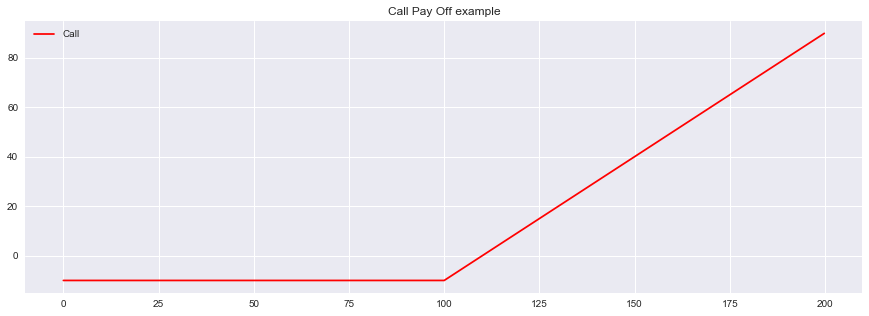

In [140]:
sns.set(rc={'figure.figsize':(15,5)})
S = [t/5 for t in range(0,1000)] 
payOff =  list(map(lambda x: max(x - 100, 0) - 10, S))
plt.plot(S, payOff, 'r')
plt.title('Call Pay Off example')
plt.legend(["Call"])
plt.show()

The standard approach to value European options with Monte Carlo method is to generate large number of random price paths for the underlying and discount averaged payoffs for each path. This becomes value of the option. Initial model was developed by Boyle in 1977.

We model the price of underlying as geometric Brownian motion with constant drift $\mu$ and volatility $\sigma$.



In [141]:
def GBM(x):
    return x.S * exp((x.r - 0.5 * x.sigma**2) * x.Ti + x.sigma * np.sqrt(x.Ti) * gauss(0,1.0))
def MC(x, sims=100):
    payoffs = []
    for i in range(sims):
        S_T = GBM(x)
        payoffs.append(max(0.0,S_T-x.K))
    price = np.exp(-x.r * (x.Ti)) * (sum(payoffs) / float(sims))
    return price
calls1['CallMC'] = calls1.apply(MC, axis=1)

### 5. Implied Volatility

For every market option price there must be unique volatility value given other known parameters in Black-Scholes formula. This value is called implied volatility. It is calculated by testing range of values and finding the price with minimal difference with market price. This is done since inverting Black-Scholes formula in closed form is difficult. 

Calculating implied volatility for range of strike prices and maturity dates provides us with volatility surface. Same asset with different strikes or expiration dates has different implied volatilities and is popularly called volatility smile. This contradicts the assumption made in the Black-Scholes model that the underlying has constant volatility. 

Main advantage of implied volatility is that it captures markets expectations of future and provides us with market expected volatility on at-the-money options and its probability which we use for prediction. Further we use it as a feature in machine learning tasks.

Implied volatility information of the market is significant and more complex than we were able to study in this project.


In [142]:
#slightly re-arrange parameters of call and vega to accomodate changing vol
def call1(S,K,r,sigma,Ti):
    d1 = (np.log(S/K) + (r + sigma**2/2)*Ti) / (sigma * np.sqrt(Ti))
    d2 = d1 - sigma * np.sqrt(Ti)
    c0 =  S * norm.cdf(d1) - K * exp(-r*(Ti)) * norm.cdf(d2)
    return c0, d1

def vega(S,d1,Ti):
    vega = (S * norm.pdf(d1) * np.sqrt(Ti))
    return vega

def impVol(x):
    iters = 100
    epsilon = 1.0e-5
    vol = 0.5
    for i in range(0, iters):
        price, d111 = call1(x.S,x.K,x.r,vol,x.Ti)
        veg = vega(x.S,d111,x.Ti)
        diff = x.opMidPrice - price  # our root
        if (abs(diff) < epsilon):
            return vol
        vol = vol + diff/veg # f(x) / f'(x)
    return vol

### 6. Volatility Smile

Although known for its defiances Black-Scholes model is extended in many ways to overcome them and serves practitioners as insight into the market dynamics. One well-known discrepancy is option volatility smile where Black-Scholes expect volatility to be constant though as visible in the figure below volatlity of ATM options is lower than options far OTM and ITM.

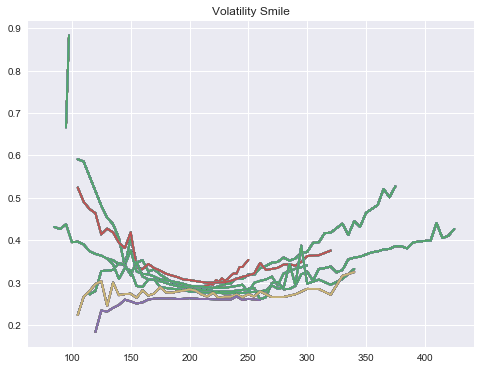

In [175]:
#calls2 = calls1.loc[calls1.Ti == calls1.Ti.iloc[501],]
#calls2['ImpVol'] = calls2.apply(impVol, axis=1)
calls1['ImpVol'] = calls1.apply(impVol, axis=1)
plt.figure(figsize=(8,6))
newDat = calls1#.loc[calls1['ImpVol'] > 0,]
for tim in calls1.Ti:
    dat = newDat.loc[newDat.Ti == tim,]
    plt.plot(dat.K,dat['ImpVol'],label=tim)
plt.title('Volatility Smile')
plt.show()

### 7. Volatility surface

An implied volatility surface is a 3-D plot that plots volatility smile and term structure of volatility in a consolidated three-dimensional surface for all options on a given underlying asset.

It is often useful to plot implied volatility as a function of both strike price and time to maturity. The result is a two-dimensional curved surface plotted in three-dimensions whereby the current market implied volatility (Z-axis) for all options on the underlying is plotted against the price or delta (Y-axis) and time to maturity (X-axis "DTM"). 

The implied volatility surface simultaneously shows both volatility smile and term structure of volatility. Option traders use an implied volatility plot to quickly determine the shape of the implied volatility surface, and to identify any areas where the slope of the plot seems out of line.

In [179]:
newDat = newDat.dropna()
newDat['diff'] = abs(newDat.S - newDat.K)
newDat = newDat.loc[newDat['diff'] < 15,]

In [177]:
ttm = newDat['Ti'].tolist()
strikes = newDat['K'].tolist()
imp_vol = newDat['ImpVol'].tolist()
f = interp2d(strikes,ttm,imp_vol, kind='cubic')
plot_strikes = np.linspace(newDat['K'].min(), newDat['K'].max(),25)
plot_ttm = np.linspace(0, newDat['Ti'].max(), 25)

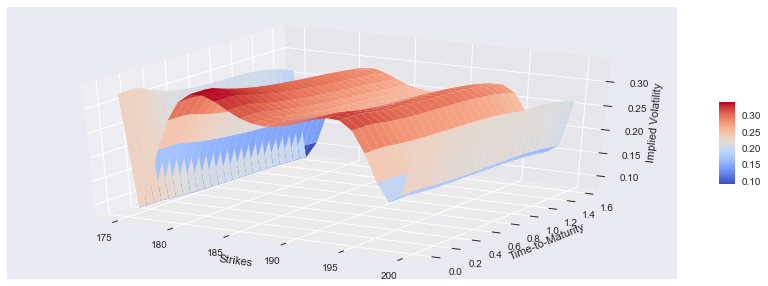

In [178]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_ttm)
Z = np.array([f(x,y) for xr, yr in zip(X, Y) for x, y in zip(xr,yr) ]).reshape(len(X), len(X[0]))
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0.1)
ax.set_xlabel('Strikes')
ax.set_ylabel('Time-to-Maturity')
ax.set_zlabel('Implied Volatility')
fig.colorbar(surf, shrink=0.3, aspect=5)

## Credits

Greatful for inspiration and downright plugging (especially You volatility surface, thanks Suhasghorp)

Derivative Analytics & Python for Finance https://github.com/yhilpisch

Black-Scholes Paper https://www.cs.princeton.edu/courses/archive/fall09/cos323/papers/black_scholes73.pdf

Taleb http://www.maths.usyd.edu.au/u/UG/SM/MATH3075/r/Haug_Taleb_2011.pdf

Clinton Howard blog https://github.com/clinthoward

http://www.codeandfinance.com/pricing-options-monte-carlo.html

http://suhasghorp.com/